In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ICLR_2018.csv')

In [ ]:
df = df.drop(['Year','ReviewId'],axis = 1)
df.head()

,ReviewText,Confidence
0,This paper proposes a method for multitask and...,4
1,The authors propose techniques for multitask a...,4
2,The idea of using cross-task transfer performa...,4
3,\nSummary: \n- This paper proposes a hand-desi...,3
4,Summary\n - This paper mainly focuses on a cou...,3


In [ ]:
df['Confidence'].value_counts()

4    1507
3     728
5     561
2     137
1      34
Name: Confidence, dtype: int64

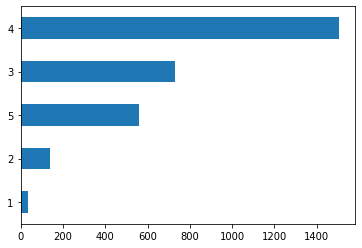

In [ ]:
label_col = pd.get_dummies(df['Confidence'])
label_col.sum().sort_values().plot(kind="barh");

365.12706437478937
22.62015503875969


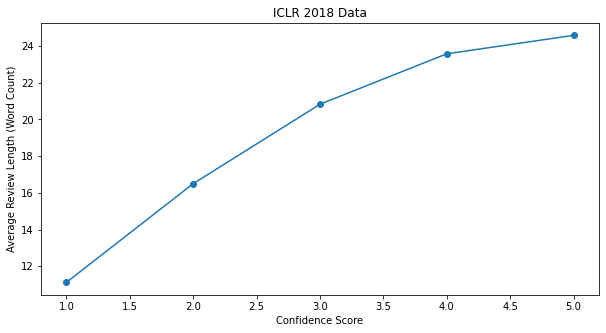

In [ ]:
df['rev_words'] = df['ReviewText'].astype(str).apply(lambda x : x.split(" ")).apply(lambda x : len(x))
df['rev_sentences'] = df['ReviewText'].astype(str).apply(lambda x : x.split(".")).apply(lambda x : len(x))
print(df['rev_words'].mean())
print(df['rev_sentences'].mean())
group = df.groupby('Confidence')['rev_sentences'].mean()
fig = plt.figure(figsize = (10, 5))
plt.plot(group.keys(), group , marker='o')
plt.xlabel("Confidence Score")
plt.ylabel("Average Review Length (Word Count)")
plt.title("ICLR 2018 Data")
plt.show()

In [ ]:
print("mean words for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_words"].mean()))
print("mean words for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_words"].mean()))
print("mean sentences for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_sentences"].mean()))
print("mean sentences for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_sentences"].mean()))

mean words for Confidence >= 3 371.71888412017165
mean words for Confidence < 3 257.34502923976606
mean sentences for Confidence >= 3 23.06008583690987
mean sentences for Confidence < 3 15.426900584795321


In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df['ReviewText'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# X = corpus
# y = df.iloc[:, 1].values
# # y = label_binarize(y, classes=[1, 2, 3, 4, 5])
# # n_classes = y.shape[1]

# # Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1), 
    dtype='double',
)
data = vectorizer.fit_transform(corpus)
vectors=data
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(data)
data=tfidf_transformer.transform(data)

In [ ]:
data.shape

(2967, 12595)

Reducing the dimentionality of the data

In [ ]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=50)
data = pca.fit_transform(data)

In [ ]:
data.shape

(2967, 12595)

In [ ]:
y = df.iloc[:, 1].values
# y = label_binarize(y, classes=[1, 2, 3, 4, 5])
n_classes = 5

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(2373, 12595)
(2373,)


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)

### Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
from matplotlib import pyplot
import seaborn as sns
def metrics(expected , predicted):
  # Mean absolute error
  print("The rmse is " + str(np.sqrt(mean_squared_error(expected, predicted))))
  print("The mae is " + str(mean_absolute_error(expected, predicted)))
  print("The r2 is " + str(r2_score(expected, predicted)))
  print("Standard Deviation of predicted" + str(np.std(predicted)))
  plt.figure()
  ax1 = sns.distplot(predicted)
  ax2 = sns.distplot(expected)
  plt.axvline(np.mean(predicted) , color='b' , linestyle='dashed' , linewidth='2')
  plt.axvline(np.mean(expected) , color='orange' , linestyle='dashed' , linewidth='2')
  # pyplot.plot(err)
  # pyplot.xticks(ticks=[i for i in range(len(err))], labels=predicted)
  # pyplot.xlabel('Predicted Value')
  # pyplot.ylabel('Mean Squared Error')
  # pyplot.show()
  # mean sq error
  # r2


The rmse is 0.9448026232702206
The mae is 0.7395540920258089
The r2 is -0.358680315563487
Standard Deviation of predicted0.7940233443444166
And for training values -------------------
The rmse is 0.06120330427198825
The mae is 0.003090338572847839
The r2 is 0.9946237271708054
Standard Deviation of predicted0.8324604846232144


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

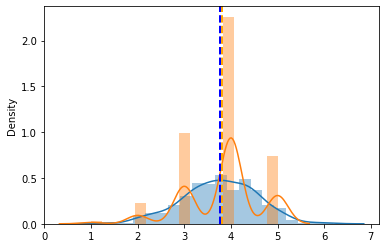

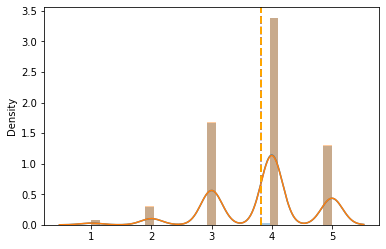

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

## SVM

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [ ]:
regressor.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)

### Metrics

The rmse is 0.76220204187807
The mae is 0.5771187074684287
The r2 is 0.11574949134526324
Standard Deviation of predicted0.23662702257832136
And for training values -------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The rmse is 0.3514399142111136
The mae is 0.20612854701326444
The r2 is 0.8227306187349069
Standard Deviation of predicted0.5715940218766798


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


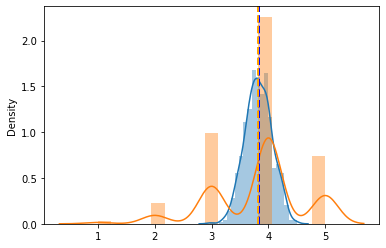

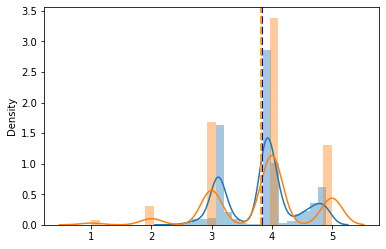

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

### Metrics

The rmse is 1.055698298970646
The mae is 0.767863823419379
The r2 is -0.6963471993949146
Standard Deviation of predicted0.8664365460861105
And for training values -------------------
The rmse is 0.061203304271984005
The mae is 0.0030903216743924707
The r2 is 0.994623727170806
Standard Deviation of predicted0.8324604845500695


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

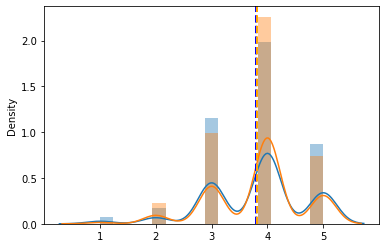

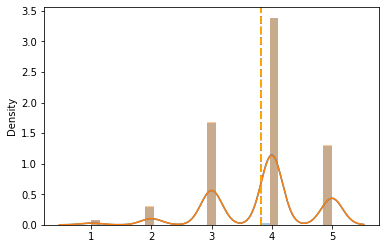

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

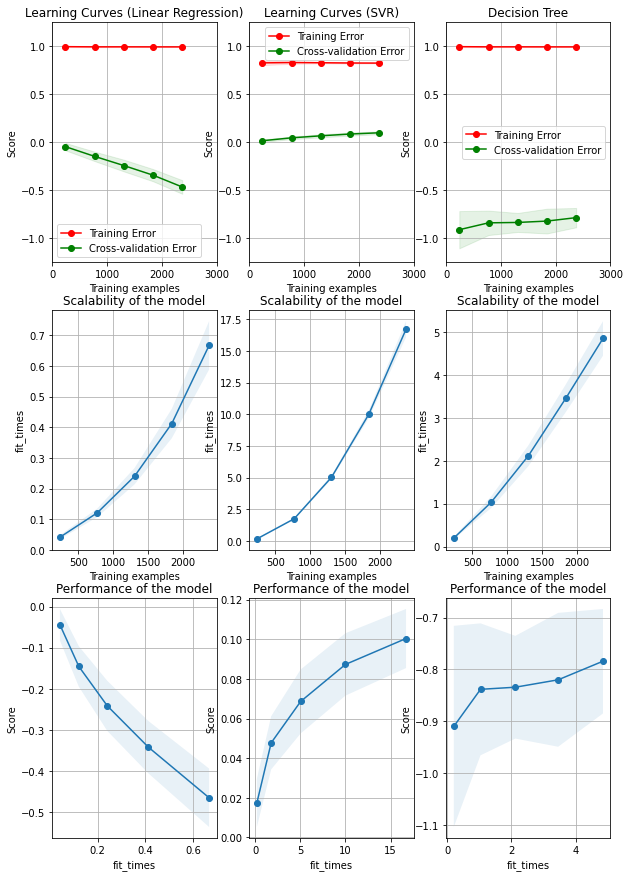

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
  
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim((-1.25,1.25))
        axes[0].set_xlim((0,3000))
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    # print("these are the test scores mean" + str(test_scores_mean))
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training Error")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation Error")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(10, 15))


title = "Learning Curves (Linear Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# train_test_split(data, y, test_size = 0.20, random_state = 0)
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(estimator, title, data, y, axes=axes[:, 0], ylim=(min(y), max(y)),
                    cv=cv, n_jobs=4)

title = "Learning Curves (SVR)"
# SVC is more expensive so we do a lower number of CV iterations:

estimator = SVR(kernel='rbf')
plot_learning_curve(estimator, title, data, y, axes=axes[:, 1], ylim=(min(y), max(y)),
                    cv=cv, n_jobs=4)

title = "Decision Tree"
estimator = DecisionTreeRegressor()

plot_learning_curve(estimator, title, data, y, axes=axes[:, 2], ylim=(min(y), max(y)),
                    cv=cv, n_jobs=4)

plt.show()

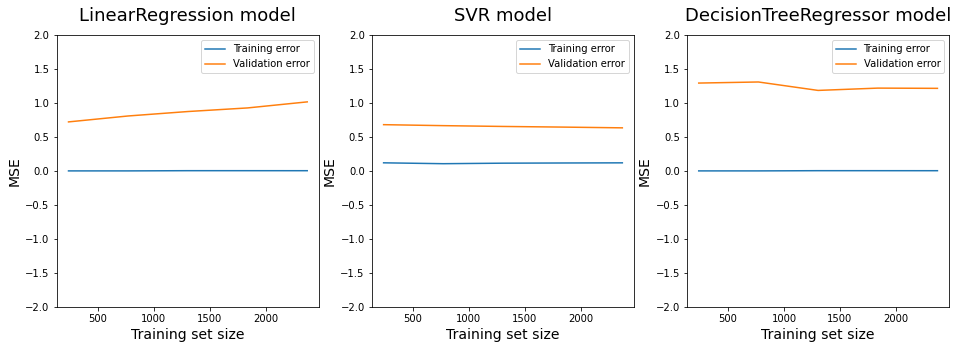

In [ ]:
def learning_curves(estimator, data, X, y, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, X, y, train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    # fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    # ax.set_ylim([-2,2])
    # ax.xlim([0, 3000])
    # plt.set_xlim((0,3000))
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = '' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(-2,2)

### Plotting the two learning curves ###

from sklearn.ensemble import RandomForestRegressor

plt.figure(figsize = (16,5))

for model, i in [(LinearRegression(),1) , (SVR(kernel='rbf') , 2) , (DecisionTreeRegressor() , 3)]:
    plt.subplot(1,3,i)
    learning_curves(model, df, data, y, np.linspace(0.1, 1.0, 5), 5)

## Custom Neural Network

In [ ]:
X_train.shape

(2373, 12595)

In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
model = Sequential()
model.add(Dense(13, input_dim=12595, kernel_initializer='normal', activation='relu'))
model.add(Dense(6, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,batch_size=32,epochs=50)
predicted = model.predict(X_test)

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

# ICLR 2019

In [ ]:
from google.colab import files
df = files.upload()

Saving 2019_iclr.csv to 2019_iclr.csv


In [ ]:
df = pd.read_csv("/content/2019_iclr.csv")

In [ ]:
df.head()

,Unnamed: 0,title,review,rating,confidence,Decision
0,0,An interesting approach ; some concerns regard...,The paper proposes an approach to learn nonlin...,4: Ok but not good enough - rejection,5: The reviewer is absolutely certain that the...,NaN
1,1,A easy-to-follow paper on nonlinear Granger ca...,"This paper aims to estimate time-delayed, nonl...",4: Ok but not good enough - rejection,4: The reviewer is confident but not absolutel...,NaN
2,2,Interesting approach,"In the manuscript entitled ""Neural Causal Disc...","8: Top 50% of accepted papers, clear accept",4: The reviewer is confident but not absolutel...,NaN
3,3,unconvincing experiments; original theorem sta...,NaN,NaN,4: The area chair is confident but not absolut...,Reject
4,4,"The paper is not bad technically, but the cont...",Major Contribution:\nThis paper details a meth...,4: Ok but not good enough - rejection,5: The reviewer is absolutely certain that the...,NaN


In [ ]:
df = df.drop(['title','Decision' , "rating" , "Unnamed: 0"],axis = 1)
df.dropna(inplace=True)
df["confidence"] = df['confidence'].apply(lambda x : x[0])
df.rename(columns = {"review" : "ReviewText" , "confidence" : "Confidence"} , inplace=True)
# df.reset_index(inplace=True)
df.head()

,ReviewText,Confidence
0,The paper proposes an approach to learn nonlin...,5
1,"This paper aims to estimate time-delayed, nonl...",4
2,"In the manuscript entitled ""Neural Causal Disc...",4
4,Major Contribution:\nThis paper details a meth...,5
5,# Summary\n\nThis submission proposes a multi-...,4


In [ ]:
df['Confidence'].value_counts()

4    2378
3    1239
5     832
2     275
1      40
Name: Confidence, dtype: int64

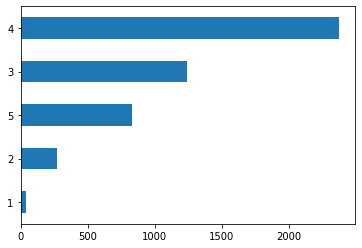

In [ ]:
label_col = pd.get_dummies(df['Confidence'])
label_col.sum().sort_values().plot(kind="barh");

394.8352225020991
24.49790092359362


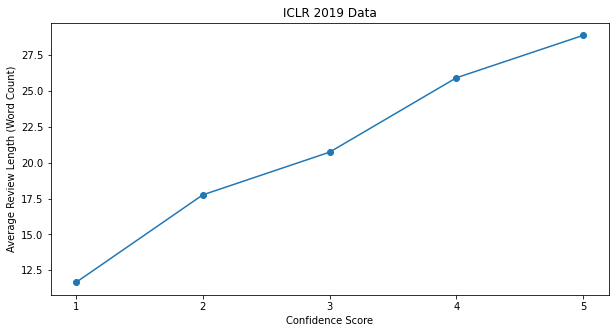

In [ ]:
df['rev_words'] = df['ReviewText'].astype(str).apply(lambda x : x.split(" ")).apply(lambda x : len(x))
df['rev_sentences'] = df['ReviewText'].astype(str).apply(lambda x : x.split(".")).apply(lambda x : len(x))
print(df['rev_words'].mean())
print(df['rev_sentences'].mean())
group = df.groupby('Confidence')['rev_sentences'].mean()
fig = plt.figure(figsize = (10, 5))
plt.plot(group.keys(), group , marker='o')
plt.xlabel("Confidence Score")
plt.ylabel("Average Review Length (Word Count)")
plt.title("ICLR 2019 Data")
plt.show()

In [ ]:
df['Confidence'] = df['Confidence'].astype(int)

In [ ]:
print("mean words for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_words"].mean()))
print("mean words for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_words"].mean()))
print("mean sentences for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_sentences"].mean()))
print("mean sentences for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_sentences"].mean()))

mean words for Confidence >= 3 403.2539896605979
mean words for Confidence < 3 275.9301587301587
mean sentences for Confidence >= 3 25.030119127893908
mean sentences for Confidence < 3 16.98095238095238


In [ ]:
df = df.reset_index()

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df['ReviewText'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# X = corpus
# y = df.iloc[:, 1].values
# # y = label_binarize(y, classes=[1, 2, 3, 4, 5])
# # n_classes = y.shape[1]

# # Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1), 
    dtype='double',
)
data = vectorizer.fit_transform(corpus)
vectors=data
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(data)
data=tfidf_transformer.transform(data)

In [ ]:
data.shape

(4764, 16144)

Reducing the dimentionality of the data

In [ ]:
# from sklearn.decomposition import TruncatedSVD
# pca = TruncatedSVD(n_components=50)
# data = pca.fit_transform(data)

In [ ]:
data.shape

(4764, 16144)

In [ ]:
df.head()

,index,ReviewText,Confidence,rev_words,rev_sentences
0,0,The paper proposes an approach to learn nonlin...,5,228,15
1,1,"This paper aims to estimate time-delayed, nonl...",4,490,27
2,2,"In the manuscript entitled ""Neural Causal Disc...",4,336,12
3,4,Major Contribution:\nThis paper details a meth...,5,369,20
4,5,# Summary\n\nThis submission proposes a multi-...,4,1022,60


In [ ]:
df["Confidence"] = df["Confidence"].astype(int)
y = df.iloc[:, 2].values
# y = label_binarize(y, classes=[1, 2, 3, 4, 5])
n_classes = 5

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(3811, 16144)
(3811,)


In [ ]:
y_train

array([4, 3, 3, ..., 4, 3, 3])

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)
predicted2 = regressor.predict(X_train)

### Metrics

The rmse is 1.0999355331577774
The mae is 0.8594639800934433
The r2 is -0.7085468778375095
Standard Deviation of predicted0.8575488567609791
And for training values -------------------
The rmse is 0.043037465537463945
The mae is 0.00240791005690701
The r2 is 0.9972982307026684
Standard Deviation of predicted0.8268658986015296


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

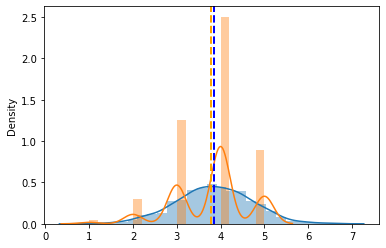

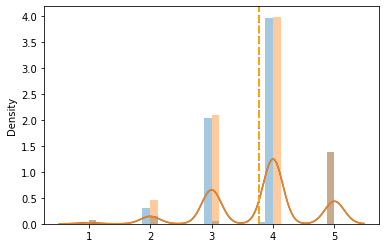

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
metrics(y_train , predicted2)

## SVM

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [ ]:
regressor.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)

### Metrics

The rmse is 0.804502388069291
The mae is 0.6256784317070239
The r2 is 0.08599807541514692
Standard Deviation of predicted0.2673052031753006
And for training values -------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The rmse is 0.3409705030097394
The mae is 0.20981914441780208
The r2 is 0.8304145817947587
Standard Deviation of predicted0.566506671834053


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


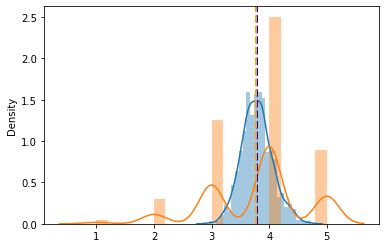

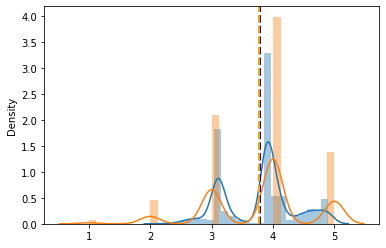

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)

### Metrics

The rmse is 1.1162232377734558
The mae is 0.8129745077464354
The r2 is -0.7595214032103281
Standard Deviation of predicted0.8337127412754703
And for training values -------------------
The rmse is 0.04303746553745506
The mae is 0.002407890471853921
The r2 is 0.9972982307026695
Standard Deviation of predicted0.8268658985092269


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

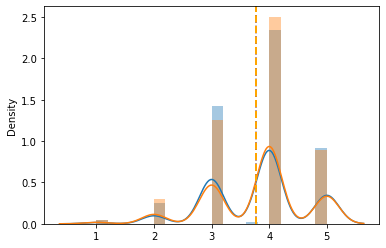

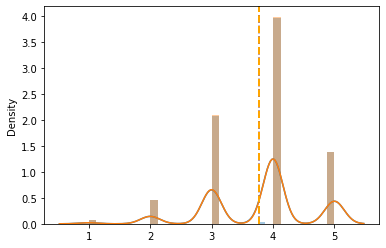

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

## Custom Neural Network

In [ ]:
X_train.shape

(3811, 16144)

In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
model = Sequential()
model.add(Dense(13, input_dim=16144, kernel_initializer='normal', activation='relu'))
model.add(Dense(6, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,batch_size=16,epochs=100)
predicted = model.predict(X_test)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 13), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


239/239 [==============================] - 2s 5ms/step - loss: 7.7493
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 0.9438
Epoch 3/100
239/239 [==============================] - 1s 5ms/step - loss: 0.7970
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6753
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.5685
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.4742
Epoch 7/100
239/239 [==============================] - 1s 5ms/step - loss: 0.3910
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.3214
Epoch 9/100
239/239 [==============================] - 1s 5ms/step - loss: 0.2641
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.2176
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.1812
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.1510
Epoch 13/100
239/239 [===

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

The rmse is 0.9635412078681524
The mae is 0.753575744934122
The r2 is -0.31109155750368034
Standard Deviation of predicted0.6836993
And for training values -------------------
The rmse is 0.3018161497064817
The mae is 0.23120146754126228
The r2 is 0.8671260532154459
Standard Deviation of predicted0.5629110502006863


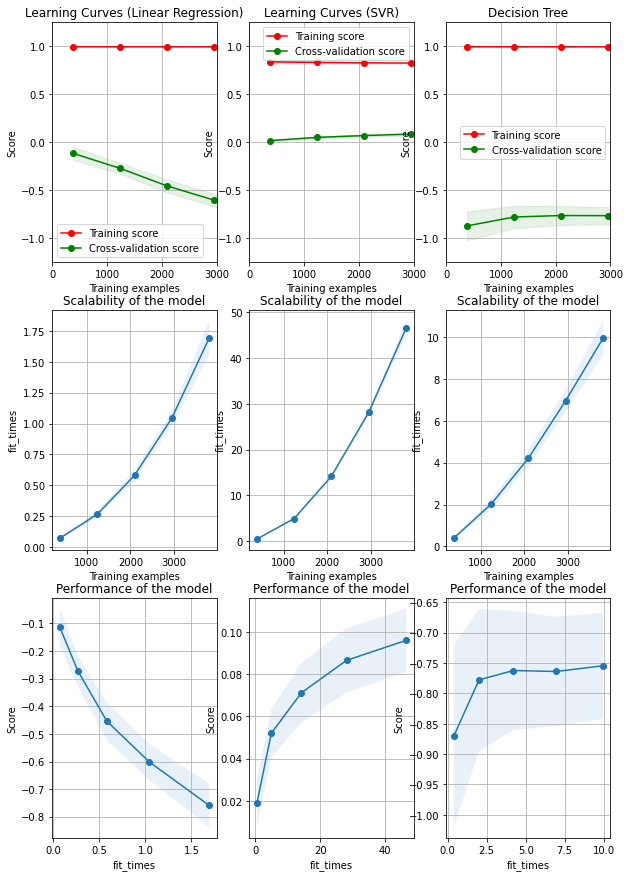

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
  
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim((-1.25,1.25))
        axes[0].set_xlim((0,3000))
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    # print("these are the test scores mean" + str(test_scores_mean))
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(10, 15))


title = "Learning Curves (Linear Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# train_test_split(data, y, test_size = 0.20, random_state = 0)
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(estimator, title, data, y, axes=axes[:, 0], ylim=(min(y), max(y)),
                    cv=cv, n_jobs=4)

title = "Learning Curves (SVR)"
# SVC is more expensive so we do a lower number of CV iterations:

estimator = SVR(kernel='rbf')
plot_learning_curve(estimator, title, data, y, axes=axes[:, 1], ylim=(min(y), max(y)),
                    cv=cv, n_jobs=4)

title = "Decision Tree"
estimator = DecisionTreeRegressor()

plot_learning_curve(estimator, title, data, y, axes=axes[:, 2], ylim=(min(y), max(y)),
                    cv=cv, n_jobs=4)

plt.show()

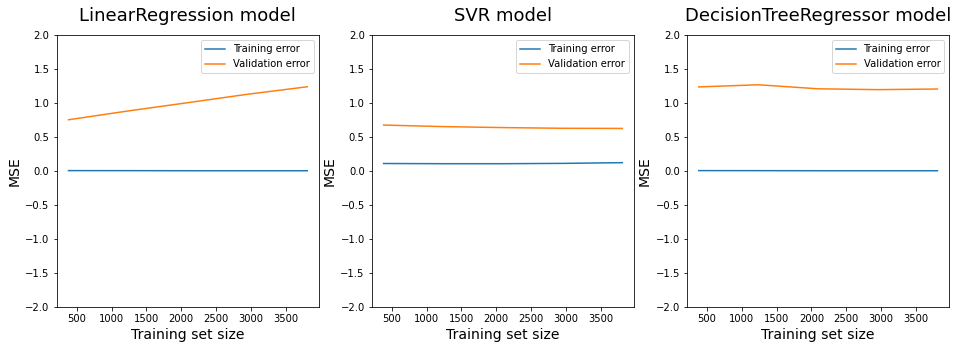

In [ ]:
def learning_curves(estimator, data, X, y, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, X, y, train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    # fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    # ax.set_ylim([-2,2])
    # ax.xlim([0, 3000])
    # plt.set_xlim((0,3000))
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = '' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(-2,2)

### Plotting the two learning curves ###

from sklearn.ensemble import RandomForestRegressor

plt.figure(figsize = (16,5))

for model, i in [(LinearRegression(),1) , (SVR(kernel='rbf') , 2) , (DecisionTreeRegressor() , 3)]:
    plt.subplot(1,3,i)
    learning_curves(model, df, data, y, np.linspace(0.1, 1.0, 5), 5)

# 2021

In [ ]:
from google.colab import files
df = files.upload()

Saving 2021_iclr.csv to 2021_iclr.csv


In [ ]:
import pandas as pd
df = pd.read_csv("/content/2021_iclr.csv")

In [ ]:
df.head()

,review,rating,confidence
0,Review:\n\nThis paper carries out a large-scal...,"Rating: 7: Good paper, accept",Confidence: 4: The reviewer is confident but n...
1,Review:\n\n###################################...,"Rating: 9: Top 15% of accepted papers, strong ...",Confidence: 3: The reviewer is fairly confiden...
2,Review:\n\nThe authors survey a wide variety o...,"Rating: 9: Top 15% of accepted papers, strong ...",Confidence: 3: The reviewer is fairly confiden...
3,Review:\n\nThe paper presents an empirical eva...,"Rating: 7: Good paper, accept",Confidence: 4: The reviewer is confident but n...
4,"Review:\n\nIn general, it is not clear, at lea...","Rating: 9: Top 15% of accepted papers, strong ...",Confidence: 4: The reviewer is confident but n...


In [ ]:
df = df.drop(["rating"],axis = 1)
df.dropna(inplace=True)
df["confidence"] = df['confidence'].apply(lambda x : x[12])
df.rename(columns = {"review" : "ReviewText" , "confidence" : "Confidence"} , inplace=True)
# df.reset_index(inplace=True)
df.head()

,ReviewText,Confidence
0,Review:\n\nThis paper carries out a large-scal...,4
1,Review:\n\n###################################...,3
2,Review:\n\nThe authors survey a wide variety o...,3
3,Review:\n\nThe paper presents an empirical eva...,4
4,"Review:\n\nIn general, it is not clear, at lea...",4


In [ ]:
df['Confidence'].value_counts()

4    1610
3    1042
5     413
2     199
1      26
Name: Confidence, dtype: int64

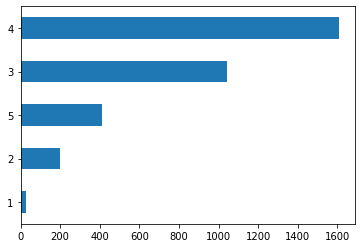

In [ ]:
label_col = pd.get_dummies(df['Confidence'])
label_col.sum().sort_values().plot(kind="barh");

436.4914893617021
26.26869300911854


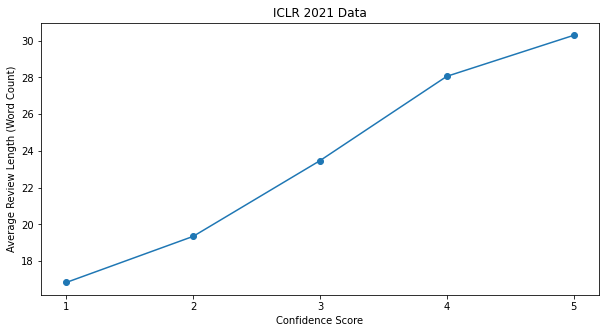

In [ ]:
df['rev_words'] = df['ReviewText'].astype(str).apply(lambda x : x.split(" ")).apply(lambda x : len(x))
df['rev_sentences'] = df['ReviewText'].astype(str).apply(lambda x : x.split(".")).apply(lambda x : len(x))
print(df['rev_words'].mean())
print(df['rev_sentences'].mean())
group = df.groupby('Confidence')['rev_sentences'].mean()
fig = plt.figure(figsize = (10, 5))
plt.plot(group.keys(), group , marker='o')
plt.xlabel("Confidence Score")
plt.ylabel("Average Review Length (Word Count)")
plt.title("ICLR 2021 Data")
plt.show()

In [ ]:
df = df.reset_index()

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df['ReviewText'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# X = corpus
# y = df.iloc[:, 1].values
# # y = label_binarize(y, classes=[1, 2, 3, 4, 5])
# # n_classes = y.shape[1]

# # Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1), 
    dtype='double',
)
data = vectorizer.fit_transform(corpus)
vectors=data
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(data)
data=tfidf_transformer.transform(data)

In [ ]:
data.shape

(3290, 14834)

Reducing the dimentionality of the data

In [ ]:
# from sklearn.decomposition import TruncatedSVD
# pca = TruncatedSVD(n_components=50)
# data = pca.fit_transform(data)

In [ ]:
data.shape

(3290, 14834)

In [ ]:
df.head()

,index,ReviewText,Confidence,rev_words,rev_sentences
0,0,Review:\n\nThis paper carries out a large-scal...,4,372,22
1,1,Review:\n\n###################################...,3,97,9
2,2,Review:\n\nThe authors survey a wide variety o...,3,1061,66
3,3,Review:\n\nThe paper presents an empirical eva...,4,246,16
4,4,"Review:\n\nIn general, it is not clear, at lea...",4,536,36


In [ ]:
df["Confidence"] = df["Confidence"].astype(int)

In [ ]:
print("mean words for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_words"].mean()))
print("mean words for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_words"].mean()))
print("mean sentences for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_sentences"].mean()))
print("mean sentences for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_sentences"].mean()))

mean words for Confidence >= 3 445.68613376835236
mean words for Confidence < 3 311.24
mean sentences for Confidence >= 3 26.797716150081566
mean sentences for Confidence < 3 19.06222222222222


In [ ]:
df["Confidence"] = df["Confidence"].astype(int)
y = df.iloc[:, 2].values
# y = label_binarize(y, classes=[1, 2, 3, 4, 5])
n_classes = 5

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(2632, 14834)
(2632,)


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
expected = y_test
predicted = regression.predict(X_test)

### Metrics

The rmse is 1.0348447247243338
The mae is 0.8284562938625281
The r2 is -0.6961801165791295
Standard Deviation of predicted0.7716885559954546
And for training values -------------------
The rmse is 4.0735159808278247e-07
The mae is 3.041830535663357e-07
The r2 is 0.9999999999997429
Standard Deviation of predicted0.8032989565354883


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

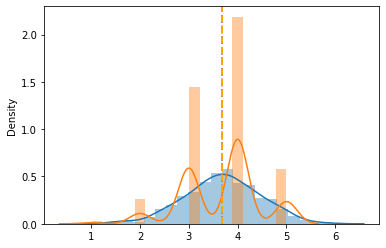

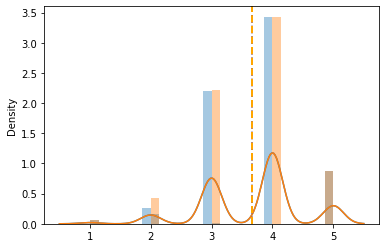

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regression.predict(X_train)
metrics(y_train , predicted2)

In [ ]:
# plt.figure(figsize=(7,7))
# plt.scatter(y_test, predicted, c='crimson')
# p1 = max(max(predicted), max(y_test))
# p2 = min(min(predicted), min(y_test))
# plt.plot([p1, p2], [p1, p2], 'b-')
# plt.xlabel('True Values', fontsize=15)
# plt.ylabel('Predictions', fontsize=15)
# plt.axis('equal')
# plt.show()

## SVM

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [ ]:
regressor.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)

### Metrics

The rmse is 0.7761732761927603
The mae is 0.6286698318239567
The r2 is 0.04580099519582692
Standard Deviation of predicted0.21604830660518112
And for training values -------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The rmse is 0.3422994023307361
The mae is 0.21214483359130218
The r2 is 0.8184242383422676
Standard Deviation of predicted0.5226183309909411


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


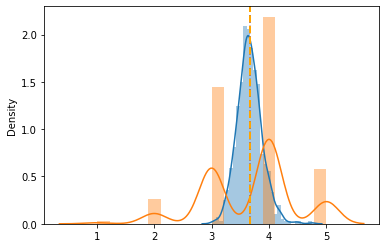

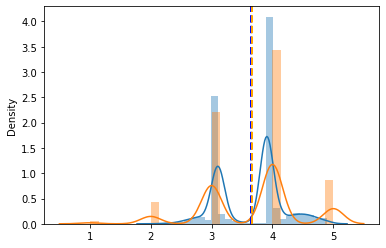

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

In [ ]:
# plt.figure(figsize=(7,7))
# plt.scatter(y_test, predicted, c='crimson')
# p1 = max(max(predicted), max(y_test))
# p2 = min(min(predicted), min(y_test))
# plt.plot([p1, p2], [p1, p2], 'b-')
# plt.xlabel('True Values', fontsize=15)
# plt.ylabel('Predictions', fontsize=15)
# plt.axis('equal')
# plt.show()

## Decision Tree

In [ ]:
X_train.shape

(2632, 14834)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)

### Metrics

The rmse is 1.0619131671036408
The mae is 0.7781155015197568
The r2 is -0.7860746203682363
Standard Deviation of predicted0.7900879487437601
And for training values -------------------
The rmse is 0.0
The mae is 0.0
The r2 is 1.0
Standard Deviation of predicted0.8032989578802913


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

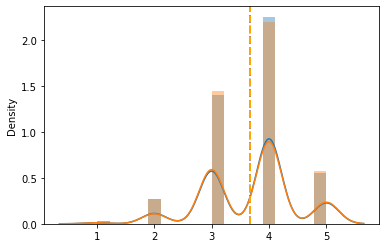

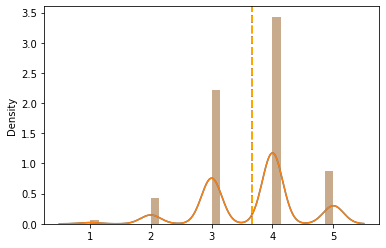

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

In [ ]:
# plt.figure(figsize=(7,7))
# plt.scatter(y_test, predicted, c='crimson')
# p1 = max(max(predicted), max(y_test))
# p2 = min(min(predicted), min(y_test))
# plt.plot([p1, p2], [p1, p2], 'b-')
# plt.xlabel('True Values', fontsize=15)
# plt.ylabel('Predictions', fontsize=15)
# plt.axis('equal')
# plt.show()

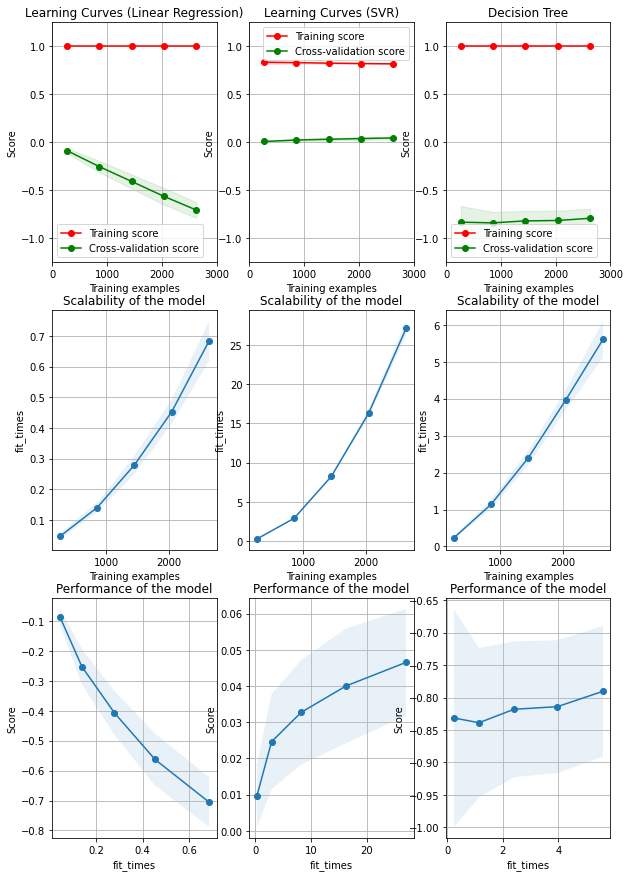

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
  
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim((-1.25,1.25))
        axes[0].set_xlim((0,3000))
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    # print("these are the test scores mean" + str(test_scores_mean))
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(10, 15))


title = "Learning Curves (Linear Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# train_test_split(data, y, test_size = 0.20, random_state = 0)
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(estimator, title, data, y, axes=axes[:, 0], ylim=(min(y), max(y)),
                    cv=cv, n_jobs=4)

title = "Learning Curves (SVR)"
# SVC is more expensive so we do a lower number of CV iterations:

estimator = SVR(kernel='rbf')
plot_learning_curve(estimator, title, data, y, axes=axes[:, 1], ylim=(min(y), max(y)),
                    cv=cv, n_jobs=4)

title = "Decision Tree"
estimator = DecisionTreeRegressor()

plot_learning_curve(estimator, title, data, y, axes=axes[:, 2], ylim=(min(y), max(y)),
                    cv=cv, n_jobs=4)

plt.show()

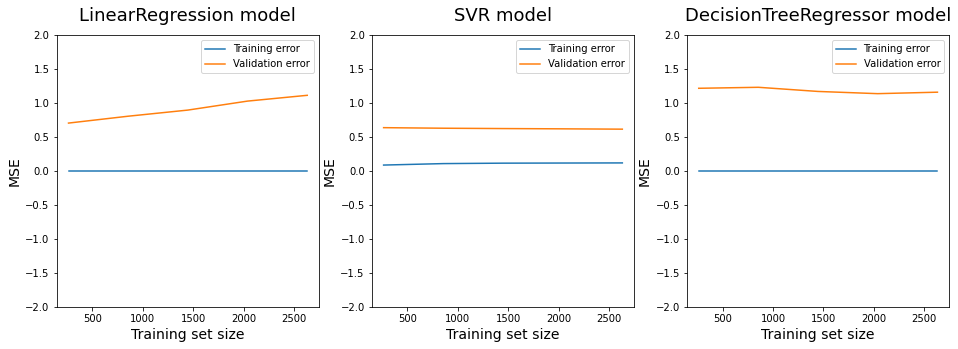

In [ ]:
plt.figure(figsize = (16,5))

for model, i in [(LinearRegression(),1) , (SVR(kernel='rbf') , 2) , (DecisionTreeRegressor() , 3)]:
    plt.subplot(1,3,i)
    learning_curves(model, df, data, y, np.linspace(0.1, 1.0, 5), 5)

## Custom Neural Network

In [ ]:
X_train.shape

(2632, 14834)

In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
model = Sequential()
model.add(Dense(13, input_dim=14834, kernel_initializer='normal', activation='relu'))
model.add(Dense(6, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,batch_size=16,epochs=100)
predicted = model.predict(X_test)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_3/dense_9/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_3/dense_9/embedding_lookup_sparse/Reshape:0", shape=(None, 13), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_3/dense_9/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


165/165 [==============================] - 1s 4ms/step - loss: 8.6063
Epoch 2/100
165/165 [==============================] - 1s 4ms/step - loss: 0.8622
Epoch 3/100
165/165 [==============================] - 1s 4ms/step - loss: 0.6954
Epoch 4/100
165/165 [==============================] - 1s 4ms/step - loss: 0.5381
Epoch 5/100
165/165 [==============================] - 1s 4ms/step - loss: 0.4138
Epoch 6/100
165/165 [==============================] - 1s 4ms/step - loss: 0.3217
Epoch 7/100
165/165 [==============================] - 1s 4ms/step - loss: 0.2497
Epoch 8/100
165/165 [==============================] - 1s 4ms/step - loss: 0.1950
Epoch 9/100
165/165 [==============================] - 1s 4ms/step - loss: 0.1521
Epoch 10/100
165/165 [==============================] - 1s 4ms/step - loss: 0.1190
Epoch 11/100
165/165 [==============================] - 1s 4ms/step - loss: 0.0929
Epoch 12/100
165/165 [==============================] - 1s 4ms/step - loss: 0.0728
Epoch 13/100
165/165 [===

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

The rmse is 0.9474547925116279
The mae is 0.7575351300572915
The r2 is -0.42180023437277736
Standard Deviation of predicted0.65119463
And for training values -------------------
The rmse is 0.8406469140147682
The mae is 0.6909422492401216
The r2 is -0.09514806200718007
Standard Deviation of predicted0.2828071441376737


## XGBoost

In [ ]:
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

[08:00:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

The rmse is 0.7708468928541502
The mae is 0.6175101241804546
The r2 is 0.0588521813051992
Standard Deviation of predicted0.21605022
And for training values -------------------
The rmse is 0.6194945757666431
The mae is 0.506624120618797
The r2 is 0.40526895530214213
Standard Deviation of predicted0.2820461


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
regressor = AdaBoostRegressor()
regressor.fit(X_train, y_train)
expected = y_test
predicted = regressor.predict(X_test)
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

The rmse is 0.7823620922159599
The mae is 0.652700614387486
The r2 is 0.030523722791956476
Standard Deviation of predicted0.13027332199180838
And for training values -------------------
The rmse is 0.7635486287449821
The mae is 0.6389237437511494
The r2 is 0.09651905805152794
Standard Deviation of predicted0.13951604869879267


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)
expected = y_test
predicted = regressor.predict(X_test)
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

The rmse is 0.7743702619525058
The mae is 0.6237586632160625
The r2 is 0.050228965604157017
Standard Deviation of predicted0.20837075981753925
And for training values -------------------
The rmse is 0.6279921693584988
The mae is 0.5194541527030625
The r2 is 0.3888412278384463
Standard Deviation of predicted0.2719444566621361


In [ ]:
std = (np.mean(predicted) - predicted)**2
relerr = ((predicted - y_test)**2)/((np.mean(y_test) - y_test)**2)
predicted2 = regression.predict(X_train)
std2 = (np.mean(predicted2) - predicted2)**2
relerr2 = ((predicted2 - y_train)**2)/((np.mean(y_train) - y_train)**2)
plt.scatter(std, relerr, c="#1f77b4",
            s = 20)
  
plt.scatter(std2, relerr2, c ="#bcbd22",
            s = 20)
# plt.yscale('symlog')
# plt.xscale('symlog')
plt.xlabel("Standard Deviation")
plt.ylabel("Relative Error")
plt.legend(["Testing set", "Training set"])
plt.show()